# Finding Centre

This notebook demonstrates the centre finding object. Here "centre" referes to the point of maximum dose at which the cutout factor is formally defined.

It makes use of the sector integration method defined within [SectorIntegration.ipynb](SectorIntegration.ipynb). Therefore a `circle_fit` function is required and a declared minimum allowable distance based upon the smallest measurement width.

An example of using this object can be found [at the bottom of this notebook](#Example).

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Importing Modules

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

import shapely.geometry as geo

from scipy.optimize import basinhopping

import warnings

import os, sys
sys.path.append(os.path.abspath('..'))

import nbimport
sys.meta_path.append(nbimport.NotebookFinder())

from EquivalentEllipse.SectorIntegration import sector_integration

importing IPython notebook from /home/simonbiggs/github/equivalent-ellipse-spline-modelling/program/EquivalentEllipse/SectorIntegration.ipynb


/usr/local/lib/python3.4/dist-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## The functions and object

In [2]:
def shapely_cutout(XCoords,YCoords):
    """Returns the shapely cutout defined by the x and y coordinates.
    """
    return geo.Polygon(np.transpose((XCoords,YCoords)))

In [3]:
class find_centre(object):
    
    def __init__(self, 
                 n=5, 
                 debug=False,
                 confidence=0.001, 
                 sectors=100, 
                 ignoreErrors=True,
                 **kwargs):
        
        self.debug = debug
        self.confidence = confidence
        self.sectors = sectors
        self.ignoreErrors = ignoreErrors
        
        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
        
        self.bounds = ((np.min(self.cutoutXCoords),np.max(self.cutoutXCoords)),
                       (np.min(self.cutoutYCoords),np.max(self.cutoutYCoords)))
        
#         self.minDistance = kwargs['minDistance']
        
        self.basinNoise = np.hypot(np.diff(self.cutout.bounds[::2]),np.diff(self.cutout.bounds[1::2]))/3
                
        self.circle_fit = kwargs['circle_fit']
        
        self.numCalls = 0
        self.basinRequiredSuccess = n
        self.centre = self.centre_basinhopping()
        
    
    
    def minimise_function(self, centre):
        
        sectorIntegrationInstance = sector_integration(x=self.cutoutXCoords,
                                                       y=self.cutoutYCoords,
                                                       circle_fit=self.circle_fit,
                                                       centre=centre,
                                                       sectors=self.sectors, # minDistance=self.minDistance,                                                       
                                                       ignoreErrors=self.ignoreErrors)
        
        self.numCalls += 1
        
        return -sectorIntegrationInstance.factor
        
    
    def centre_basinhopping(self):
        
        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'L-BFGS-B',
                           "options": {'gtol': self.confidence},
                           "bounds": self.bounds}
        
        initial_input = np.array([0,0])
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)   
        
        return basinhoppingOutput.x
    
    
    def step_function(self,optimiserInput):
        
        
        
        optimiserInput[0] += np.random.normal(scale=self.basinNoise)   # x-position
        optimiserInput[1] += np.random.normal(scale=self.basinNoise)   # y-position
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
        """Callback function used by self.ellipse_basinhopping.
        """        
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + self.confidence:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - self.confidence:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - self.confidence:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True    
        
        


## Execute no further if being imported

Don't want to waste time running the example if this notebook is just being imported. The following cell triggers the notebook import to stop.

In [ ]:
'stop nbimport'

## Example

### Defining the circle fit from example measured factors

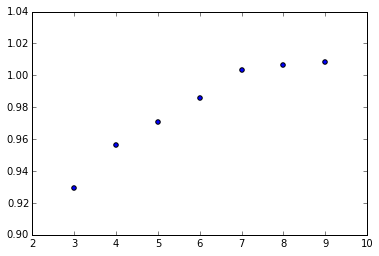

In [4]:
circle_diameter = np.array([3,4,5,6,7,8,9])
circle_factors = np.array([0.9296,0.9562,0.9705,0.9858,1.0032,1.0067,1.0084])

plt.scatter(circle_diameter, circle_factors)

Since the sector integration method is only being used as a relative estimate for the optimiser radii greater than 4.5 are given a factor equal to the largest factor, and radii smaller than the minimum measurement have a factor of 0 so that the optimiser avoids them.

In [9]:
from scipy.interpolate import UnivariateSpline

def circle_fit(radii):
    
    circle_radii = circle_diameter/2
    
    spline = UnivariateSpline(circle_radii, circle_factors)
    results = spline(radii)
    
    results[radii>np.max(circle_radii)] = np.max(circle_factors)
    results[radii<np.min(circle_radii)] = 0
    
    return results

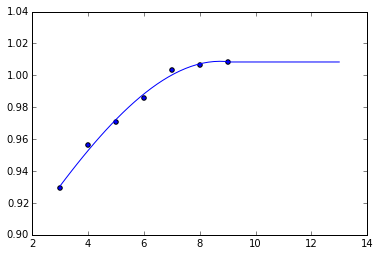

In [10]:
t = np.linspace(circle_diameter.min(),13)
y = circle_fit(t/2)

plt.scatter(circle_diameter, circle_factors)
plt.plot(t,y)

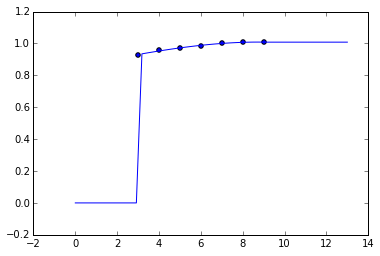

In [11]:
t = np.linspace(0,13)
y = circle_fit(t/2)

plt.scatter(circle_diameter, circle_factors)
plt.plot(t,y)

### Defining the cutout

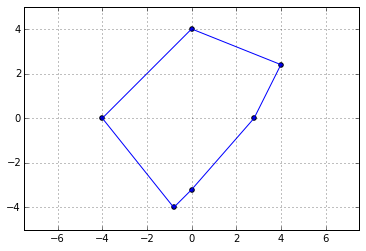

In [12]:
XCoords = np.array([-1,-0.2,0,0.7,1,0])*4
YCoords = np.array([0,-1,-.8,0,.6,1])*4

plt.scatter(XCoords, YCoords)
plt.plot(np.append(XCoords, XCoords[0]), 
         np.append(YCoords, YCoords[0]))
plt.axis("equal")
plt.grid(True)

### Find the centre

In [13]:
exampleFindCentre = find_centre(x=XCoords,
                                y=YCoords,
                                circle_fit=circle_fit,
                                minDistance=1.5,
                                ignoreErrors=True)

# Need to produce minimum distance warning

(-5.0, 5.0, -5.0, 5.0)

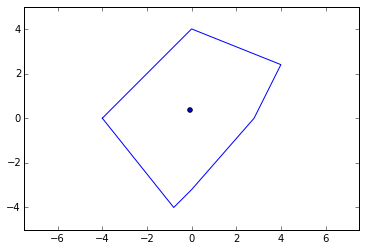

In [14]:
plt.plot(exampleFindCentre.cutout.exterior.xy[0], exampleFindCentre.cutout.exterior.xy[1])
plt.scatter(exampleFindCentre.centre[0], exampleFindCentre.centre[1])

plt.axis("equal")

In [15]:
print(exampleFindCentre.centre)

[-0.09149842  0.37386134]
